In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from dateutil.relativedelta import relativedelta

In [3]:
customers = pd.read_csv("C:\\Users\\jaban\\Downloads\\OLIST\\data\\olist_customers_dataset.csv")[
    ["customer_id", "customer_unique_id"]
].copy()

orders = pd.read_csv(
    "C:\\Users\\jaban\\Downloads\\OLIST\\data\\olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)[["order_id", "customer_id", "order_purchase_timestamp"]].copy()

order_items = (
    pd.read_csv("C:\\Users\\jaban\\Downloads\\OLIST\\data\\olist_order_items_dataset.csv")[
        ["order_id", "price", "freight_value"]
    ]
    .groupby("order_id")
    .agg("sum")
    .reset_index()
    .copy()
)

order_reviews = pd.read_csv(
    "C:\\Users\\jaban\\Downloads\\OLIST\\data\\olist_order_reviews_dataset.csv",
    parse_dates=[
        "review_creation_date",
        "review_answer_timestamp",
    ],
)[["review_creation_date", "review_score", "order_id"]]

start_date = orders["order_purchase_timestamp"].min()
end_date = orders["order_purchase_timestamp"].max()


def get_customers(months, customers_ids=[]):
    end_date = start_date + relativedelta(months=months)

    orders_items = order_items.copy()
    s_orders_items["total_value"] = (
        s_orders_items["price"] + s_orders_items["freight_value"]
    )

    s_orders = orders.copy()

    orders_period = (
        s_orders.order_purchase_timestamp >= start_date.strftime("%Y-%m-%d")
    ) & (s_orders.order_purchase_timestamp <= end_date.strftime("%Y-%m-%d"))
    s_orders = s_orders.loc[orders_period, :]
    s_orders = s_orders.merge(
        s_orders_items[["order_id", "total_value"]], on="order_id"
    )

    order_reviews_period = (
        order_reviews.review_creation_date >= start_date.strftime("%Y-%m-%d")
    ) & (order_reviews.review_creation_date <= end_date.strftime("%Y-%m-%d"))
    s_order_reviews = order_reviews.loc[order_reviews_period, :]

    s_customers = (
        customers.merge(s_orders, on="customer_id")
        .merge(s_order_reviews, on="order_id")
        .groupby("customer_unique_id")
        .agg(
            first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
            last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
            frequency=pd.NamedAgg(column="order_id", aggfunc="nunique"),
            monetary=pd.NamedAgg(column="total_value", aggfunc="sum"),
            review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        )
        .reset_index()
    )

    s_customers["recency"] = (
        s_customers["last_order"] - s_customers["first_order"]
    ).dt.days + 1
    s_customers = s_customers.set_index("customer_unique_id")

    s_customers = s_customers[["recency", "frequency", "monetary", "review_score"]]

    if customers_ids:
        return s_customers.loc[customers_ids]
    return s_customers


def prepare_data_for_model(customers: pd.DataFrame):
    scaler = StandardScaler()

    return scaler.fit_transform(customers)


def get_trained_model(month_group, customers_ids=[], verbose=False):
    customers = get_customers(month_group, customers_ids=customers_ids)

    if verbose:
        print(
            "Trained on {0} Customers until Group Month {1}".format(
                str(customers.shape[0]), str(month_group)
            )
        )

    scaled_customers = prepare_data_for_model(customers)

    return AgglomerativeClustering(
        n_clusters=4, linkage="ward", affinity="euclidean", compute_full_tree=False
    ).fit(scaled_customers)


def predict_group_labels(trained_model, month_group, model_name, verbose=False):
    customers = get_customers(month_group)

    if verbose:
        print(
            "Predict {0} Customers Labels for original group By {1}".format(
                str(customers.shape[0]), model_name
            )
        )

    model_labels = trained_model.labels_

    return model_labels[: customers.shape[0]]

In [4]:
def get_ari_graph(months_of_training, verbose=False):
    # customers_ids = get_customers(months_of_training).index.to_list()

    end_date = start_date + relativedelta(months=13)

    # s_orders_items = order_items.copy()
    order_items["total_value"] = (
        order_items["price"] + order_items["freight_value"]
    )

    s_orders = orders.copy()

    orders_period = (
        s_orders.order_purchase_timestamp >= start_date.strftime("%Y-%m-%d")
    ) & (s_orders.order_purchase_timestamp <= end_date.strftime("%Y-%m-%d"))
    s_orders = s_orders.loc[orders_period, :]
    s_orders = s_orders.merge(
        order_items[["order_id", "total_value"]], on="order_id"
    )

    order_reviews_period = (
        order_reviews.review_creation_date >= start_date.strftime("%Y-%m-%d")
    ) & (order_reviews.review_creation_date <= end_date.strftime("%Y-%m-%d"))
    s_order_reviews = order_reviews.loc[order_reviews_period, :]

    s_customers = (
        customers.merge(s_orders, on="customer_id")
        .merge(s_order_reviews, on="order_id")
        .groupby("customer_unique_id")
        .agg(
            first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
            last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
            frequency=pd.NamedAgg(column="order_id", aggfunc="nunique"),
            monetary=pd.NamedAgg(column="total_value", aggfunc="sum"),
            review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        )
        .reset_index()
    )

    s_customers["recency"] = (
        s_customers["last_order"] - s_customers["first_order"]
    ).dt.days + 1
    s_customers = s_customers.set_index("customer_unique_id")

    s_customers = s_customers[["recency", "frequency", "monetary", "review_score"]]

    if customers_ids:
        return s_customers.loc[customers_ids]
    return s_customers







    
    m1 = get_trained_model(months_of_training)
    true_labels = m1.labels_

    ari_scores = []

    for model in range(2, (25 - (months_of_training - 2))):
        group_month = model + (months_of_training - 1)
        # Train the model with the new data
        new_model = get_trained_model(group_month, customers_ids, verbose)

        # Get the predicted labels predicted by the new model
        predicted_labels = predict_group_labels(
            new_model, months_of_training, f"Model {group_month}", verbose
        )

        ari_scores.append(
            {
                "month": model - 1,
                "ari_score": adjusted_rand_score(true_labels, predicted_labels),
            }
        )

    pd.DataFrame(ari_scores).plot(
        title="Evolution of ARI Score per Month", x="month", y="ari_score"
    )

Trained on 25094 Customers until Group Month 14
Predict 25094 Customers Labels for original group By Model 14
Trained on 25094 Customers until Group Month 15
Predict 25094 Customers Labels for original group By Model 15
Trained on 25094 Customers until Group Month 16
Predict 25094 Customers Labels for original group By Model 16
Trained on 25094 Customers until Group Month 17
Predict 25094 Customers Labels for original group By Model 17
Trained on 25094 Customers until Group Month 18
Predict 25094 Customers Labels for original group By Model 18
Trained on 25094 Customers until Group Month 19
Predict 25094 Customers Labels for original group By Model 19
Trained on 25094 Customers until Group Month 20
Predict 25094 Customers Labels for original group By Model 20
Trained on 25094 Customers until Group Month 21
Predict 25094 Customers Labels for original group By Model 21
Trained on 25094 Customers until Group Month 22
Predict 25094 Customers Labels for original group By Model 22
Trained on

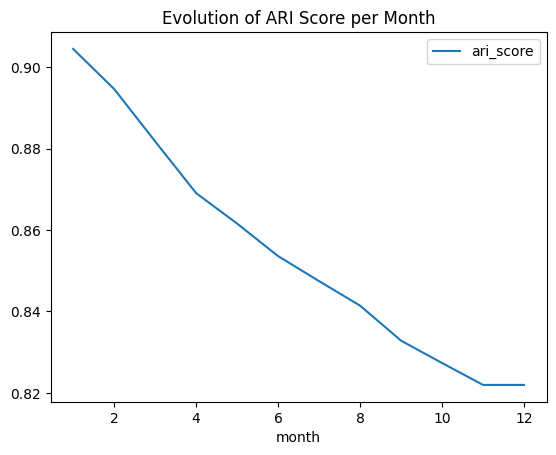

In [5]:
# Create the DataFrame of ARI Scores (~25k of Customers)

get_ari_graph(13, verbose=True)